In [36]:
import CCA_EU 
from scipy.stats import ks_2samp
from CCA_EU import kernel_expo_square

import numpy as np
import seaborn as sns
import pandas as pd
from scipy.signal import fftconvolve
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy

import altair as alt

import geopandas as gpd

import rasterio as rio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.windows import Window

from shapely.ops import transform

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import cm
from matplotlib.colors import to_rgba
from matplotlib.ticker import FormatStrFormatter
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2
from matplotlib_scalebar.scalebar import ScaleBar

import pickle

In [2]:
FUAs = [ 'Avignon','Poitiers','Belfast','Blackwater','Enschede','Utrecht','Leuven',
        'Mons','Mönchengladbach','Wuppertal']
# countries = ['France','France','UnitedKingdom','UnitedKingdom','Netherlands','Netherlands',
#              'Belgium','Belgium','Germany','Germany']
# country_fua_zip = zip(FUAs,countries)

In [109]:
with open(r'results_EU\kl_maps\ks_values0014change.pickle', 'rb') as handle:
    ks_values0014change = pickle.load(handle) 
with open(r'results_EU\kl_maps\ks_values7500change.pickle', 'rb') as handle:
    ks_values7500change = pickle.load(handle)
with open(r'results_EU\kl_maps\ks_values2014change.pickle', 'rb') as handle:
    ks_values2014change = pickle.load(handle)
    
with open(r'results_EU\kl_maps\ks_values0014genesis.pickle', 'rb') as handle:
    ks_values0014genesis = pickle.load(handle) 
with open(r'results_EU\kl_maps\ks_values7500genesis.pickle', 'rb') as handle:
    ks_values7500genesis = pickle.load(handle)
with open(r'results_EU\kl_maps\ks_values2014genesis.pickle', 'rb') as handle:
    ks_values2014genesis = pickle.load(handle)

In [110]:
def plot_ks(i=0,timeperiod=0):
    
    fua = FUAs[i]
    ks_change = [ks_values7500change,ks_values0014change,ks_values2014change]
    ks_genesis = [ks_values7500genesis,ks_values0014genesis,ks_values2014genesis]
    
    ks_change_df = pd.DataFrame(np.transpose(ks_change[timeperiod][i]),columns=FUAs)
    ks_genesis_df = pd.DataFrame(np.transpose(ks_genesis[timeperiod][i]),columns=FUAs)
    
    cross_change = FUAs.copy()
    compact_change = [cross_change[j] for j in [2]]
    compact_genesis = [cross_change[j] for j in [1,2]]
    mediumC_change = [cross_change[j] for j in [1,4]]
    mediumC_genesis = [cross_change[j] for j in [0,3,4,9]]
    mediumS_change = [cross_change[j] for j in [0,5,9]]
    mediumS_genesis = [cross_change[j] for j in [5,7,8]]
    sprawl_change = [cross_change[j] for j in [3,6,7,8]]
    sprawl_genesis = [cross_change[j] for j in [6]]
    own_change = cross_change.pop(i)

    compact_change_en = ks_change_df[compact_change].values.tolist()
    compact_change_en = [item for sublist in compact_change_en for item in sublist]
    compact_genesis_en = ks_genesis_df[compact_genesis].values.tolist()
    compact_genesis_en = [item for sublist in compact_genesis_en for item in sublist]
    compact = compact_change_en+compact_genesis_en
    
    mediumC_change_en = ks_change_df[mediumC_change].values.tolist()
    mediumC_change_en = [item for sublist in mediumC_change_en for item in sublist]
    mediumC_genesis_en = ks_genesis_df[mediumC_genesis].values.tolist()
    mediumC_genesis_en = [item for sublist in mediumC_genesis_en for item in sublist]
    mediumC = mediumC_change_en+mediumC_genesis_en
    
    mediumS_change_en = ks_change_df[mediumS_change].values.tolist()
    mediumS_change_en = [item for sublist in mediumS_change_en for item in sublist]
    mediumS_genesis_en = ks_genesis_df[mediumS_genesis].values.tolist()
    mediumS_genesis_en = [item for sublist in mediumS_genesis_en for item in sublist]
    mediumS = mediumS_change_en+mediumS_genesis_en
    
    sprawl_change_en = ks_change_df[sprawl_change].values.tolist()
    sprawl_change_en = [item for sublist in sprawl_change_en for item in sublist]
    sprawl_genesis_en = ks_genesis_df[sprawl_genesis].values.tolist()
    sprawl_genesis_en = [item for sublist in sprawl_genesis_en for item in sublist]
    sprawl = sprawl_change_en+sprawl_genesis_en
    return ks_change_df,ks_genesis_df,own_change,compact,mediumC,mediumS,sprawl

In [111]:
cali_accu = []
for i in range(10):
    ks_change_df,ks_genesis_df,own_change,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=0)
    cali_own = ks_change_df[own_change].to_numpy()
    cali_notown = np.concatenate((ks_change_df.drop([own_change],axis=1).to_numpy().flatten(),ks_genesis_df.to_numpy().flatten()), axis=0)
    trial_success = 0
    for j in range(1000):
        trial_success += np.random.choice(cali_own)<np.random.choice(cali_notown)
    cali_accu.append(trial_success/1000)

In [38]:
# cali_accu_cluster = []
# for i in range(10):
#     ks_change_df,ks_genesis_df,own_change,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=0)
#     cali_own = ks_change_df[own_change].to_numpy()
#     if i in [2]:#compact
#         cali_owncluster = np.setdiff1d(np.array(compact),cali_own)
#     elif i in [1,4]:#medium compact
#         cali_owncluster = np.setdiff1d(np.array(mediumC),cali_own)
#     elif i in [0,5,9]:#medium dispersed
#         cali_owncluster = np.setdiff1d(np.array(mediumS),cali_own)
#     elif i in [3,6,7,8]:#dispersed
#         cali_owncluster = np.setdiff1d(np.array(sprawl),cali_own)
#     trial_success = 0
#     for j in range(1000):
#         trial_success += np.random.choice(cali_own)<np.random.choice(cali_owncluster)
#     cali_accu_cluster.append(trial_success/1000)

In [112]:
proj_accu = []
for i in range(10):
    ks_change_df,ks_genesis_df,own_change,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=1)
    proj_own = ks_change_df[own_change].to_numpy()
    proj_notown = np.concatenate((ks_change_df.drop([own_change],axis=1).to_numpy().flatten(),ks_genesis_df.to_numpy().flatten()), axis=0)
    trial_success = 0
    for j in range(1000):
        trial_success += np.random.choice(proj_own)<np.random.choice(proj_notown)
    proj_accu.append(trial_success/1000)

In [43]:
# proj_accu_cluster = []
# for i in range(10):
#     ks_change_df,ks_genesis_df,own_change,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=1)
#     cali_own = ks_change_df[own_change].to_numpy()
#     if i in [2]:#compact
#         cali_owncluster = np.setdiff1d(np.array(compact),cali_own)
#     elif i in [1,4]:#medium compact
#         cali_owncluster = np.setdiff1d(np.array(mediumC),cali_own)
#     elif i in [0,5,9]:#medium dispersed
#         cali_owncluster = np.setdiff1d(np.array(mediumS),cali_own)
#     elif i in [3,6,7,8]:#dispersed
#         cali_owncluster = np.setdiff1d(np.array(sprawl),cali_own)
#     trial_success = 0
#     for j in range(1000):
#         trial_success += np.random.choice(cali_own)<np.random.choice(cali_owncluster)
#     proj_accu_cluster.append(trial_success/1000)

In [113]:
cali_accu_best = []
for i in range(10):
    ks_change_df,ks_genesis_df,own_change,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=0)
    
    not_sprawl = compact+mediumC+mediumS
    trial_success_sprawl = 0
    for j in range(1000):
        trial_success_sprawl += np.random.choice(sprawl)<np.random.choice(not_sprawl)
        
    not_compact = sprawl+mediumC+mediumS
    trial_success_compact = 0
    for j in range(1000):
        trial_success_compact += np.random.choice(compact)<np.random.choice(not_compact)
    
    not_mediumC = sprawl+compact+mediumS
    trial_success_mediumC = 0
    for j in range(1000):
        trial_success_mediumC += np.random.choice(mediumC)<np.random.choice(not_mediumC)
    
    not_mediumS = sprawl+compact+mediumS
    trial_success_mediumS = 0
    for j in range(1000):
        trial_success_mediumS += np.random.choice(mediumS)<np.random.choice(not_mediumS)
    
    cali_accu_best.append(max([trial_success_sprawl,trial_success_compact,trial_success_mediumC,trial_success_mediumS])/1000)

In [114]:
proj_accu_best = []
for i in range(10):
    ks_change_df,ks_genesis_df,own_change,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=1)
    
    not_sprawl = compact+mediumC+mediumS
    trial_success_sprawl = 0
    for j in range(1000):
        trial_success_sprawl += np.random.choice(sprawl)<np.random.choice(not_sprawl)
        
    not_compact = sprawl+mediumC+mediumS
    trial_success_compact = 0
    for j in range(1000):
        trial_success_compact += np.random.choice(compact)<np.random.choice(not_compact)
    
    not_mediumC = sprawl+compact+mediumS
    trial_success_mediumC = 0
    for j in range(1000):
        trial_success_mediumC += np.random.choice(mediumC)<np.random.choice(not_mediumC)
    
    not_mediumS = sprawl+compact+mediumS
    trial_success_mediumS = 0
    for j in range(1000):
        trial_success_mediumS += np.random.choice(mediumS)<np.random.choice(not_mediumS)
    
    proj_accu_best.append(max([trial_success_sprawl,trial_success_compact,trial_success_mediumC,trial_success_mediumS])/1000)

In [191]:
df = pd.DataFrame([cali_accu,proj_accu,cali_accu_best,proj_accu_best]).transpose()

(0.0, 1.0)

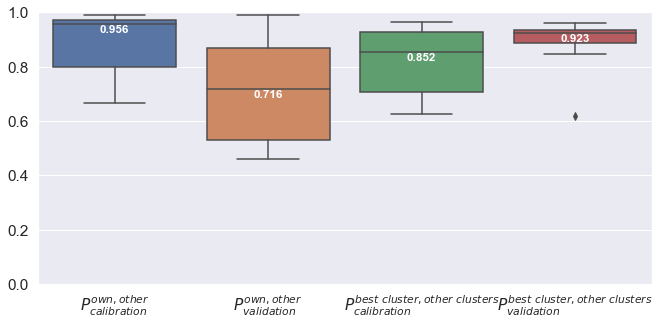

In [204]:

df.columns = ['$P_{calibration}^{own,other}$',
              '$P_{validation}^{own,other}$',
              '$P_{calibration}^{best\ cluster,other\ clusters}$',
              '$P_{validation}^{best\ cluster,other\ clusters}$']
fig,axes = plt.subplots(1,1,figsize=(11,5))
axes = sns.boxplot(data=df)

medians = df.median()

for xtick in axes.get_xticks():
    axes.text(xtick,medians[xtick]-0.03,round(medians[xtick],3), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

sns.set(font_scale = 1.4)
axes.set_ylim(0,1)

C:\Users\reneryu\AppData\Local\Temp/ipykernel_5744/3658902228.py:74: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()


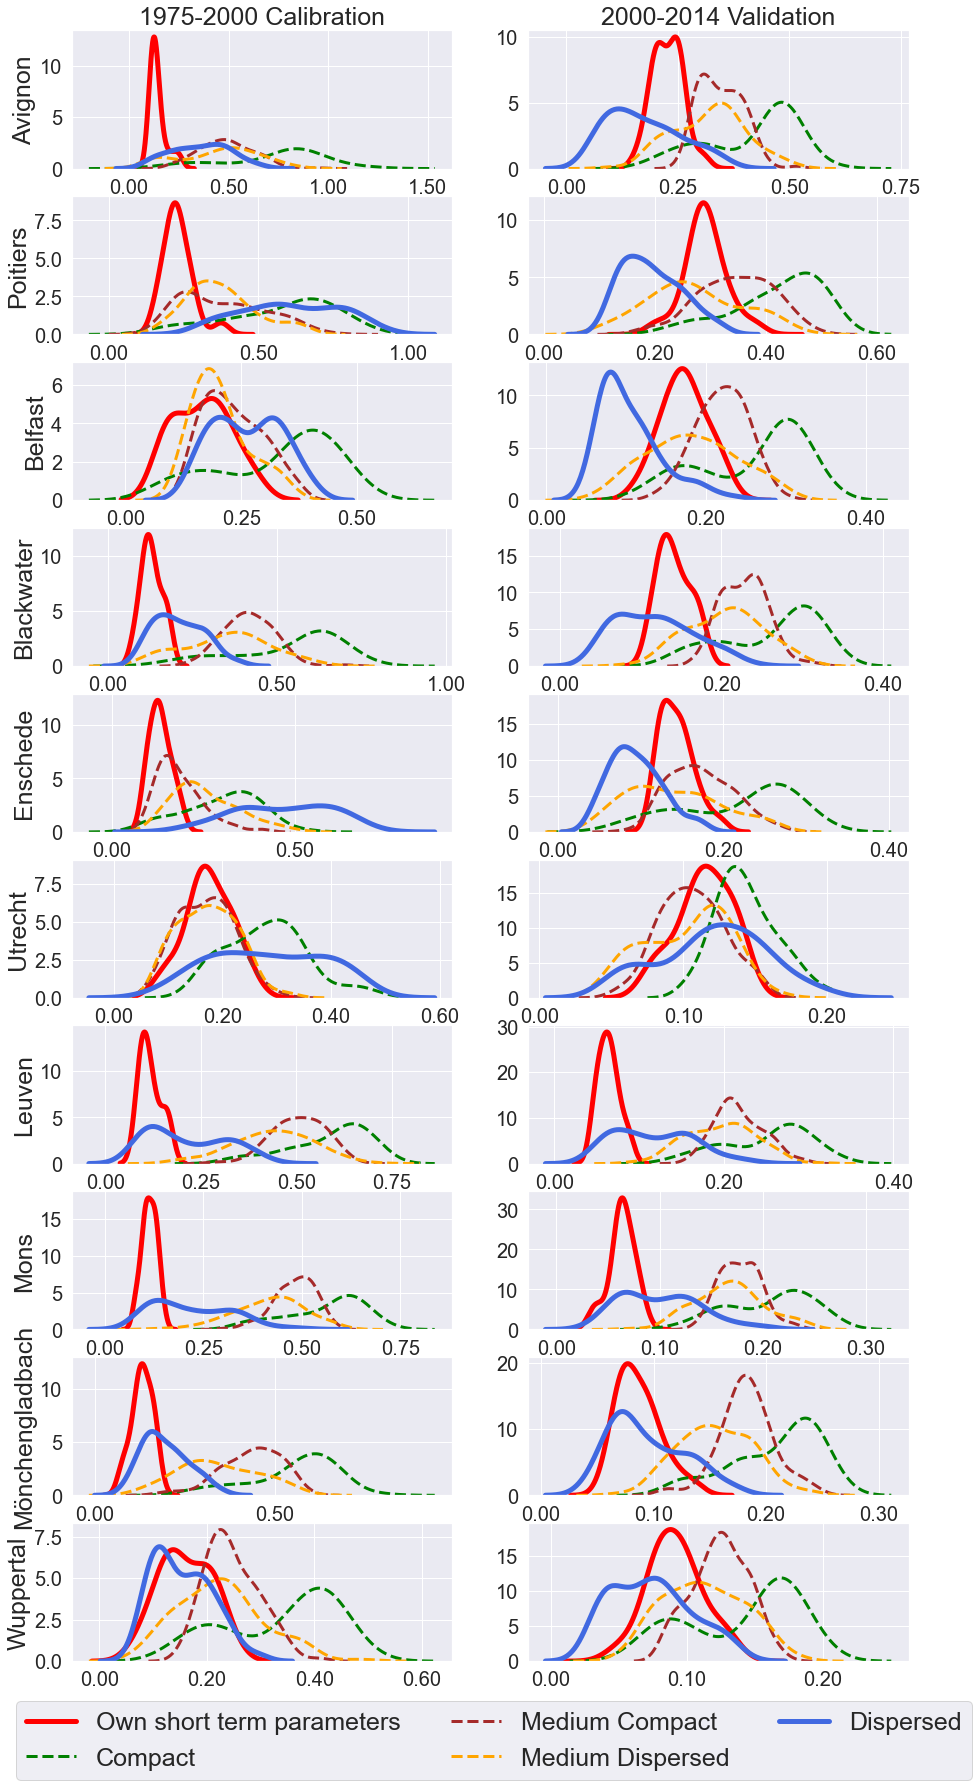

In [47]:
colors = ['green','brown','orange','royalblue','red']
fig,axes = plt.subplots(10,2,figsize=(15,30))

#75-00 calibration 
for i in range(10):
    ks_change_df,ks_genesis_df,own_change,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=0)
    kde_change = ks_change_df[own_change].plot.kde(ax=axes[i][0],label='Own short term parameters',c=colors[4],lw=5)
#     kde_pattern = ks_genesis_df[own_change].plot.kde(ax=axes[i][0],label='Own long term parameters',c='k',lw=5,ls="dotted")
    compact_kde = sns.kdeplot(compact,ax=axes[i][0],label='Compact',c=colors[0],ls="--",lw=3)
    mediumC_kde = sns.kdeplot(mediumC,ax=axes[i][0],label='Medium Compact',c=colors[1],ls="--",lw=3)
    mediumS_kde = sns.kdeplot(mediumS,ax=axes[i][0],label='Medium Dispersed',c=colors[2],ls="--",lw=3)
    sprawl_kde = sns.kdeplot(sprawl,ax=axes[i][0],label='Dispersed',c=colors[3],lw=5)
    axes[i][0].set(ylabel=None)
    axes[i][0].set_ylabel(FUAs[i],fontsize=15)
    axes[i][0].set_ylabel(FUAs[i],fontsize=25)
    axes[i][0].locator_params(axis='y', nbins=4)
    axes[i][0].locator_params(axis='x', nbins=4)
    for tick in axes[i][0].get_xticklabels():
        tick.set_fontsize(20)
    for tick in axes[i][0].get_yticklabels():
        tick.set_fontsize(20)
    axes[i][0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i==0:
        _ = axes[i][0].set_title('1975-2000 Calibration',fontsize=25,y=0.999)
#         _ = axes[i][0].legend(loc='upper right',fontsize=14)

#00-14 validation
for i in range(10):
    ks_change_df,ks_genesis_df,own_change,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=1)
    kde_change = ks_change_df[own_change].plot.kde(ax=axes[i][1],label='Own short term parameters',c=colors[4],lw=5)
#     kde_pattern = ks_genesis_df[own_change].plot.kde(ax=axes[i][1],label='Own long term parameters',c='k',lw=5,ls="dotted")
    compact_kde = sns.kdeplot(compact,ax=axes[i][1],label='Compact',c=colors[0],ls="--",lw=3)
    mediumC_kde = sns.kdeplot(mediumC,ax=axes[i][1],label='Medium Compact',c=colors[1],ls="--",lw=3)
    mediumS_kde = sns.kdeplot(mediumS,ax=axes[i][1],label='Medium Dispersed',c=colors[2],ls="--",lw=3)
    sprawl_kde = sns.kdeplot(sprawl,ax=axes[i][1],label='Dispersed',c=colors[3],lw=5)
    axes[i][1].set(ylabel=None)
    axes[i][1].locator_params(axis='y', nbins=4)
    axes[i][1].locator_params(axis='x', nbins=4)
    for tick in axes[i][1].get_xticklabels():
        tick.set_fontsize(20)
    for tick in axes[i][1].get_yticklabels():
        tick.set_fontsize(20)
    axes[i][1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i==0:
        _ = axes[i][1].set_title('2000-2014 Validation',fontsize=25,y=0.999)
        _ = axes[i][1].legend(bbox_to_anchor=(1.2,-11),fontsize=25, ncol=3)
#     if i in [0,1,2,3,4,5,9]:
#         axes[i][1].set_facecolor('xkcd:yellow')
# #0-14 genesis
# for i in range(10):
#     ks_change_df,ks_genesis_df,own_change,compact,mediumC,mediumS,sprawl = plot_ks2014(i=i)
#     kde_change = ks_change_df[own_change].plot.kde(ax=axes[i][2],label='Own short term parameters',c=colors[4],lw=5)
#     kde_pattern = ks_genesis_df[own_change].plot.kde(ax=axes[i][2],label='Own long term parameters',c='k',lw=5,ls="dotted")
#     compact_kde = sns.kdeplot(compact,ax=axes[i][2],label='Compact',c=colors[0],ls="--",lw=3)
#     mediumC_kde = sns.kdeplot(mediumC,ax=axes[i][2],label='Medium Compact',c=colors[1],ls="--",lw=3)
#     mediumS_kde = sns.kdeplot(mediumS,ax=axes[i][2],label='Medium Dispersed',c=colors[2],ls="--",lw=3)
#     sprawl_kde = sns.kdeplot(sprawl,ax=axes[i][2],label='Dispersed',c=colors[3],lw=5)
#     axes[i][2].set(ylabel=None)
#     axes[i][2].locator_params(axis='y', nbins=4)
#     axes[i][2].locator_params(axis='x', nbins=4)
#     for tick in axes[i][2].get_xticklabels():
#         tick.set_fontsize(20)
#     for tick in axes[i][2].get_yticklabels():
#         tick.set_fontsize(20)
#     axes[i][2].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#     if i==0:
#         _ = axes[i][2].set_title('0-2014 Genesis',fontsize=25,y=0.999)
#     if i in [6,7,8]:
#         axes[i][2].set_facecolor('xkcd:yellow')
        

# fig.legend(bbox_to_anchor=(0.6,1.1),fontsize=14, ncol=4)
# fig.suptitle("Calibrated Parameters Clusters' Simulations Density Kolmogorov–Smirnov Statistics\nin Calibration Period 1975-2000, Validation Period 2000-2014, Genesis Period 0-2014",y=0.97,fontsize=25)
fig.tight_layout()

In [175]:
with open(r'results_OECD\previous\ks_values7590change.pickle', 'rb') as handle:
    ks_values7590change = pickle.load(handle)
with open(r'results_OECD\previous\ks_values9000change.pickle', 'rb') as handle:
    ks_values9000change = pickle.load(handle)
with open(r'results_OECD\previous\ks_values0014change.pickle', 'rb') as handle:
    ks_values0014change = pickle.load(handle)
with open(r'results_OECD\previous\ks_values1975change.pickle', 'rb') as handle:
    ks_values1975change = pickle.load(handle)
    
with open(r'results_OECD\previous\ks_values7590genesis.pickle', 'rb') as handle:
    ks_values7590genesis = pickle.load(handle)
with open(r'results_OECD\previous\ks_values9000genesis.pickle', 'rb') as handle:
    ks_values9000genesis = pickle.load(handle)
with open(r'results_OECD\previous\ks_values0014genesis.pickle', 'rb') as handle:
    ks_values0014genesis = pickle.load(handle)
with open(r'results_OECD\previous\ks_values1975genesis.pickle', 'rb') as handle:
    ks_values1975genesis = pickle.load(handle)

In [176]:
def plot_ks(i=0,timeperiod=0):
    FUAs = ['Linz','Aarhus','Helsinki','Thessaloniki','Debrecen','Verona','Luxembourg','Bergen',
        'Braga','Bratislava','Seville','Malmö','Bern','Ankara']
    paraFUAs = [ 'Avignon','Poitiers','Belfast','Blackwater','Enschede','Utrecht','Leuven',
        'Mons','Mönchengladbach','Wuppertal']
    fua = FUAs[i]
    ks_change = [ks_values1975change,ks_values7590change,ks_values9000change,ks_values0014change]
    ks_genesis = [ks_values1975genesis,ks_values7590genesis,ks_values9000genesis,ks_values0014genesis]
    
    ks_change_df = pd.DataFrame(np.transpose(ks_change[timeperiod][i]),columns=paraFUAs)
    ks_genesis_df = pd.DataFrame(np.transpose(ks_genesis[timeperiod][i]),columns=paraFUAs)
    
    cross_change = paraFUAs.copy()
    compact_change = [cross_change[j] for j in [2]]
    compact_genesis = [cross_change[j] for j in [1,2]]
    mediumC_change = [cross_change[j] for j in [1,4]]
    mediumC_genesis = [cross_change[j] for j in [0,3,4,9]]
    mediumS_change = [cross_change[j] for j in [0,5,9]]
    mediumS_genesis = [cross_change[j] for j in [5,7,8]]
    sprawl_change = [cross_change[j] for j in [3,6,7,8]]
    sprawl_genesis = [cross_change[j] for j in [6]]

    compact_change_en = ks_change_df[compact_change].values.tolist()
    compact_change_en = [item for sublist in compact_change_en for item in sublist]
    compact_genesis_en = ks_genesis_df[compact_genesis].values.tolist()
    compact_genesis_en = [item for sublist in compact_genesis_en for item in sublist]
    compact = compact_change_en+compact_genesis_en
    
    mediumC_change_en = ks_change_df[mediumC_change].values.tolist()
    mediumC_change_en = [item for sublist in mediumC_change_en for item in sublist]
    mediumC_genesis_en = ks_genesis_df[mediumC_genesis].values.tolist()
    mediumC_genesis_en = [item for sublist in mediumC_genesis_en for item in sublist]
    mediumC = mediumC_change_en+mediumC_genesis_en
    
    mediumS_change_en = ks_change_df[mediumS_change].values.tolist()
    mediumS_change_en = [item for sublist in mediumS_change_en for item in sublist]
    mediumS_genesis_en = ks_genesis_df[mediumS_genesis].values.tolist()
    mediumS_genesis_en = [item for sublist in mediumS_genesis_en for item in sublist]
    mediumS = mediumS_change_en+mediumS_genesis_en
    
    sprawl_change_en = ks_change_df[sprawl_change].values.tolist()
    sprawl_change_en = [item for sublist in sprawl_change_en for item in sublist]
    sprawl_genesis_en = ks_genesis_df[sprawl_genesis].values.tolist()
    sprawl_genesis_en = [item for sublist in sprawl_genesis_en for item in sublist]
    sprawl = sprawl_change_en+sprawl_genesis_en
    return ks_change_df,ks_genesis_df,compact,mediumC,mediumS,sprawl

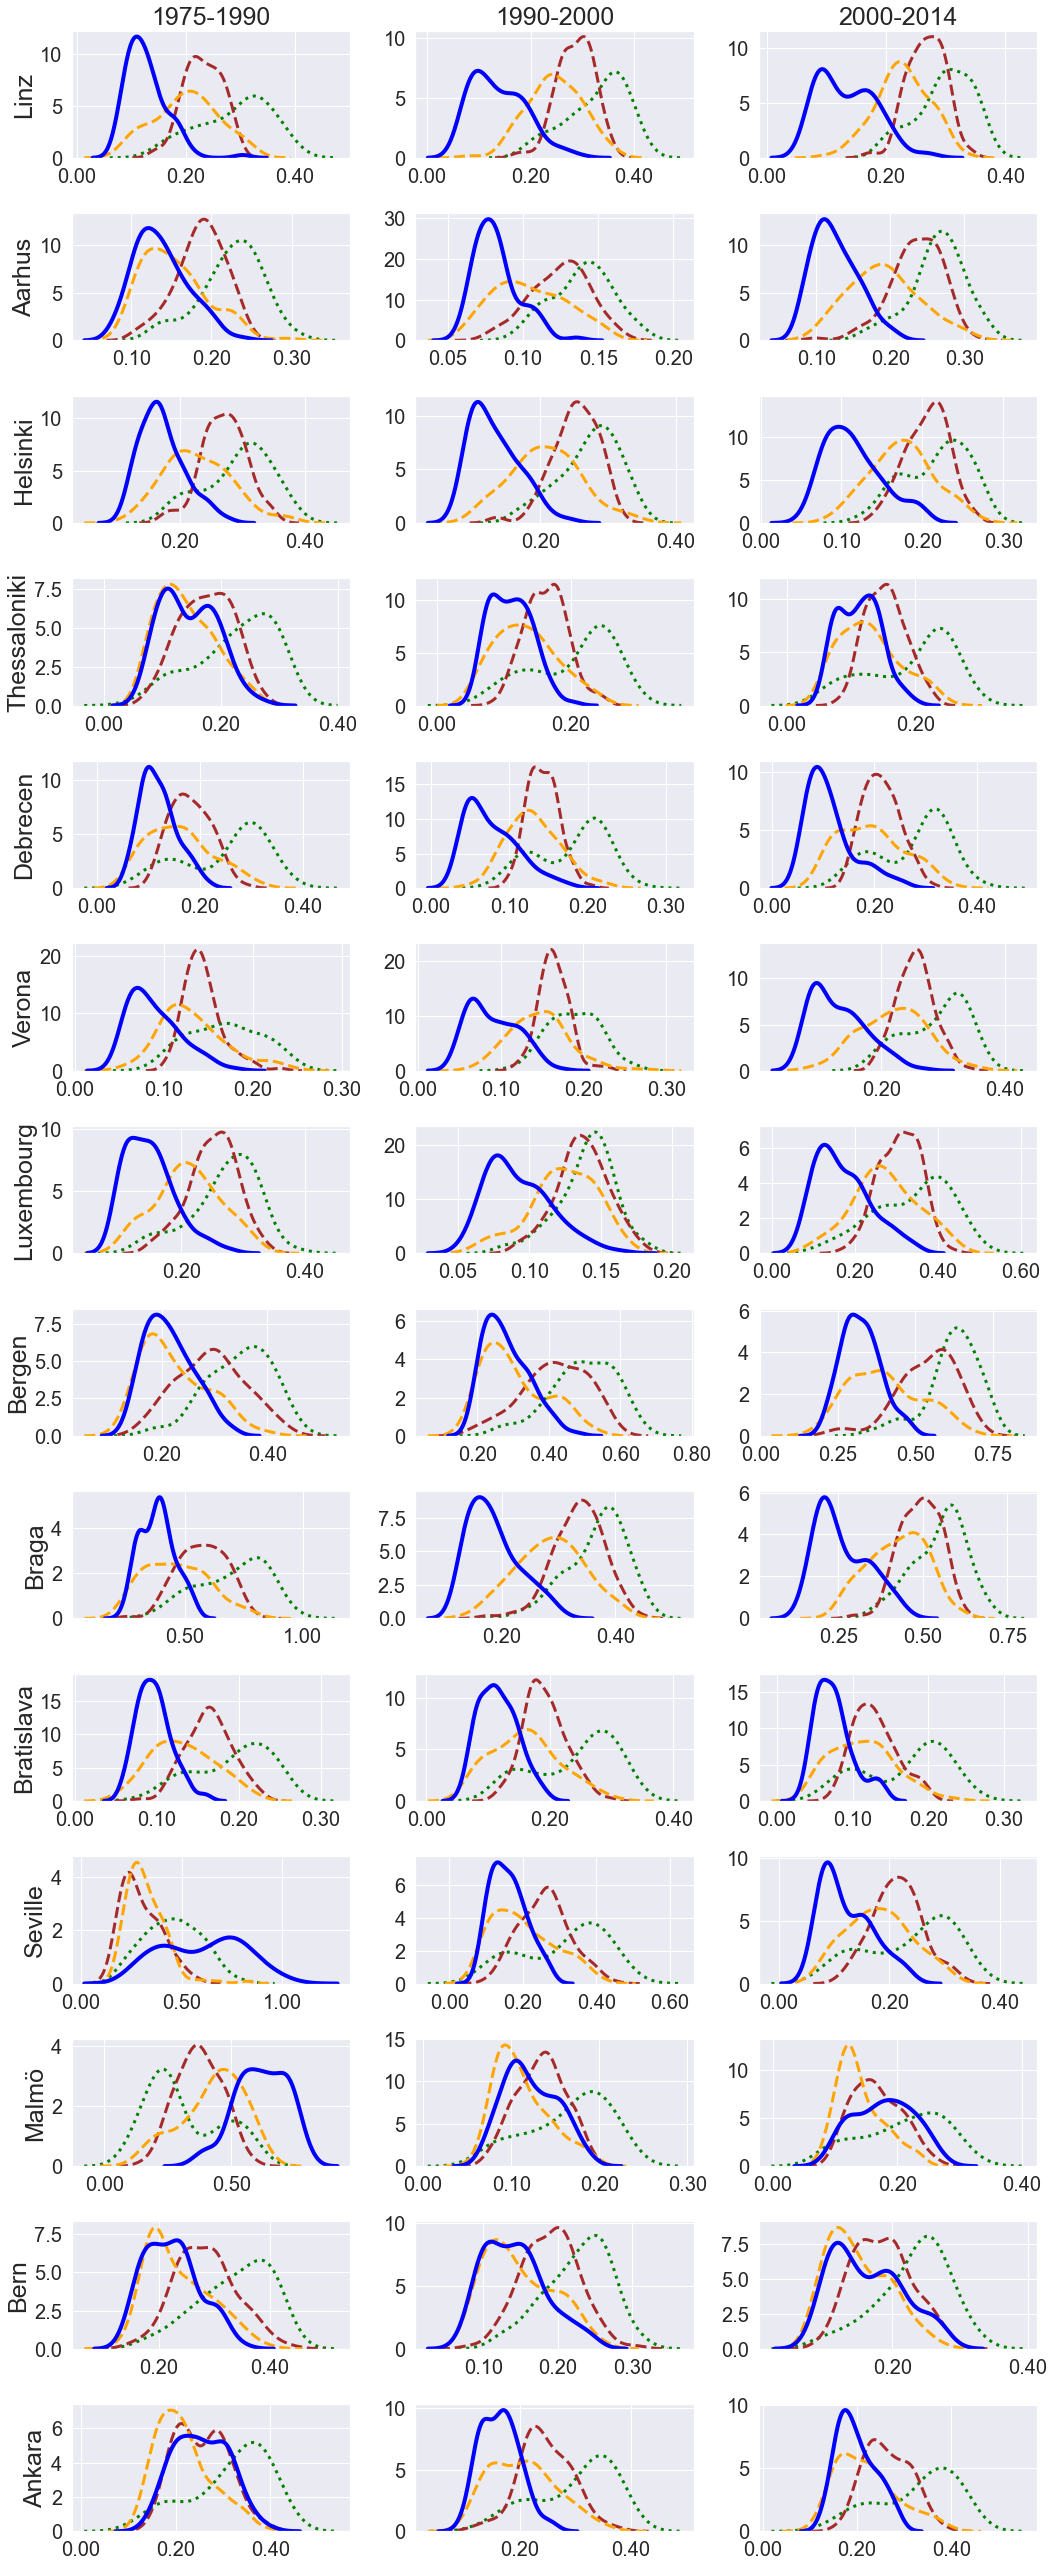

In [219]:
colors = ['green','brown','orange','blue']
fig,axes = plt.subplots(14,3,figsize=(15,36))

#75-90  
for i in range(len(FUAs)):
    ks_change_df,ks_genesis_df,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=1)
    compact_change_kde = sns.kdeplot(compact,ax=axes[i][0],label='Compact Parameters',c=colors[0],ls=":",lw=3)
    mediumC_change_kde = sns.kdeplot(mediumC,ax=axes[i][0],label='Medium Compact',c=colors[1],ls="--",lw=3)
    mediumS_change_kde = sns.kdeplot(mediumS,ax=axes[i][0],label='Medium Dispersed',c=colors[2],ls="--",lw=3)
    sprawl_change_kde = sns.kdeplot(sprawl,ax=axes[i][0],label='Dispersed Parameters',c=colors[3],lw=4)
    axes[i][0].set(ylabel=None)
    axes[i][0].set_ylabel(FUAs[i],fontsize=25)
    axes[i][0].locator_params(axis='y', nbins=4)
    axes[i][0].locator_params(axis='x', nbins=4)
    for tick in axes[i][0].get_xticklabels():
        tick.set_fontsize(20)
    for tick in axes[i][0].get_yticklabels():
        tick.set_fontsize(20)
    axes[i][0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i==0:
        _ = axes[i][0].set_title('1975-1990',fontsize=25,y=0.999)

#90-00
for i in range(len(FUAs)):
    ks_change_df,ks_genesis_df,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=2)
    compact_change_kde = sns.kdeplot(compact,ax=axes[i][1],label='Compact Parameters',c=colors[0],ls=":",lw=3)
    mediumC_change_kde = sns.kdeplot(mediumC,ax=axes[i][1],label='Medium Compact',c=colors[1],ls="--",lw=3)
    mediumS_change_kde = sns.kdeplot(mediumS,ax=axes[i][1],label='Medium Dispersed',c=colors[2],ls="--",lw=3)
    sprawl_change_kde = sns.kdeplot(sprawl,ax=axes[i][1],label='Dispersed Parameters',c=colors[3],lw=4)
    axes[i][1].set(ylabel=None)
    axes[i][1].locator_params(axis='y', nbins=4)
    axes[i][1].locator_params(axis='x', nbins=4)
    for tick in axes[i][1].get_xticklabels():
        tick.set_fontsize(20)
    for tick in axes[i][1].get_yticklabels():
        tick.set_fontsize(20)
    axes[i][1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i==0:
        _ = axes[i][1].set_title('1990-2000',fontsize=25,y=0.999)

#00-14
for i in range(len(FUAs)):
    ks_change_df,ks_genesis_df,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=3)
    compact_change_kde = sns.kdeplot(compact,ax=axes[i][2],label='Compact Parameters',c=colors[0],ls=":",lw=3)
    mediumC_change_kde = sns.kdeplot(mediumC,ax=axes[i][2],label='Medium Compact',c=colors[1],ls="--",lw=3)
    mediumS_change_kde = sns.kdeplot(mediumS,ax=axes[i][2],label='Medium Dispersed',c=colors[2],ls="--",lw=3)
    sprawl_change_kde = sns.kdeplot(sprawl,ax=axes[i][2],label='Dispersed Parameters',c=colors[3],lw=4)
    axes[i][2].set(ylabel=None)
    axes[i][2].locator_params(axis='y', nbins=4)
    axes[i][2].locator_params(axis='x', nbins=4)
    for tick in axes[i][2].get_xticklabels():
        tick.set_fontsize(20)
    for tick in axes[i][2].get_yticklabels():
        tick.set_fontsize(20)
    axes[i][2].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    if i==0:
        _ = axes[i][2].set_title('2000-2014',fontsize=25,y=0.999)
# _ = axes[i][2].legend(bbox_to_anchor=(0.99,-0.2),fontsize=20,ncol=4)

fig.tight_layout()

In [177]:
accu_7590 = []
for i in range(14):
    ks_change_df,ks_genesis_df,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=1)
    
    not_sprawl = compact+mediumC+mediumS
    trial_success_sprawl = 0
    for j in range(1000):
        trial_success_sprawl += np.random.choice(sprawl)<np.random.choice(not_sprawl)
        
    not_compact = sprawl+mediumC+mediumS
    trial_success_compact = 0
    for j in range(1000):
        trial_success_compact += np.random.choice(compact)<np.random.choice(not_compact)
    
    not_mediumC = sprawl+compact+mediumS
    trial_success_mediumC = 0
    for j in range(1000):
        trial_success_mediumC += np.random.choice(mediumC)<np.random.choice(not_mediumC)
    
    not_mediumS = sprawl+compact+mediumS
    trial_success_mediumS = 0
    for j in range(1000):
        trial_success_mediumS += np.random.choice(mediumS)<np.random.choice(not_mediumS)
    
    accu_7590.append(max([trial_success_sprawl,trial_success_compact,trial_success_mediumC,trial_success_mediumS])/1000)

In [178]:
accu_9000 = []
for i in range(14):
    ks_change_df,ks_genesis_df,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=2)
    
    not_sprawl = compact+mediumC+mediumS
    trial_success_sprawl = 0
    for j in range(1000):
        trial_success_sprawl += np.random.choice(sprawl)<np.random.choice(not_sprawl)
        
    not_compact = sprawl+mediumC+mediumS
    trial_success_compact = 0
    for j in range(1000):
        trial_success_compact += np.random.choice(compact)<np.random.choice(not_compact)
    
    not_mediumC = sprawl+compact+mediumS
    trial_success_mediumC = 0
    for j in range(1000):
        trial_success_mediumC += np.random.choice(mediumC)<np.random.choice(not_mediumC)
    
    not_mediumS = sprawl+compact+mediumS
    trial_success_mediumS = 0
    for j in range(1000):
        trial_success_mediumS += np.random.choice(mediumS)<np.random.choice(not_mediumS)
    
    accu_9000.append(max([trial_success_sprawl,trial_success_compact,trial_success_mediumC,trial_success_mediumS])/1000)

In [179]:
accu_0014 = []
for i in range(14):
    ks_change_df,ks_genesis_df,compact,mediumC,mediumS,sprawl = plot_ks(i=i,timeperiod=3)
    
    not_sprawl = compact+mediumC+mediumS
    trial_success_sprawl = 0
    for j in range(1000):
        trial_success_sprawl += np.random.choice(sprawl)<np.random.choice(not_sprawl)
        
    not_compact = sprawl+mediumC+mediumS
    trial_success_compact = 0
    for j in range(1000):
        trial_success_compact += np.random.choice(compact)<np.random.choice(not_compact)
    
    not_mediumC = sprawl+compact+mediumS
    trial_success_mediumC = 0
    for j in range(1000):
        trial_success_mediumC += np.random.choice(mediumC)<np.random.choice(not_mediumC)
    
    not_mediumS = sprawl+compact+mediumS
    trial_success_mediumS = 0
    for j in range(1000):
        trial_success_mediumS += np.random.choice(mediumS)<np.random.choice(not_mediumS)
    
    accu_0014.append(max([trial_success_sprawl,trial_success_compact,trial_success_mediumC,trial_success_mediumS])/1000)

In [205]:
df = pd.DataFrame([accu_7590,accu_9000,accu_0014]).transpose()

(0.0, 1.0)

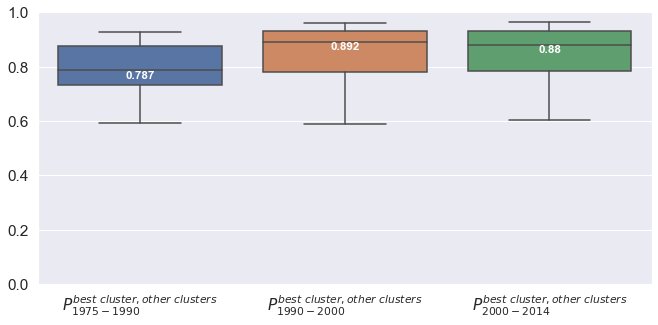

In [206]:

df.columns = ['$P_{1975-1990}^{best\ cluster, other\ clusters}$',
              '$P_{1990-2000}^{best\ cluster, other\ clusters}$',
              '$P_{2000-2014}^{best\ cluster, other\ clusters}$']

fig,axes = plt.subplots(1,1,figsize=(11,5))
axes = sns.boxplot(data=df)
medians = df.median()

for xtick in axes.get_xticks():
    axes.text(xtick,medians[xtick]-0.03,round(medians[xtick],3), 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')

sns.set(font_scale = 1.5)
axes.set_ylim(0,1)

In [138]:
FUAs = ['Linz','Aarhus','Helsinki','Thessaloniki','Debrecen','Verona','Luxembourg','Bergen',
        'Braga','Bratislava','Seville','Malmö','Bern','Ankara']

In [139]:
#period 1975-1990 best cluster counts dataframe
eddf_7590 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
for i in range(len(FUAs)):
    ks_change_df,ks_genesis_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=1)
    compact_60,mediumC_60,mediumS_60,sprawl_60 = np.sort(compact)[:60],np.sort(mediumC)[:60],np.sort(mediumS)[:60],np.sort(sprawl)[:60]
    compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                         list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
    all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
    all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
    unique, counts = np.unique(all_tuples_60tag,return_counts=True)
    eddf_7590.iloc[i] = dict(zip(unique, counts))
eddf_7590 = eddf_7590.fillna(0)
#period 1990-2000 best cluster counts dataframe
eddf_9000 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
for i in range(len(FUAs)):
    ks_change_df,ks_genesis_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=2)
    compact_60,mediumC_60,mediumS_60,sprawl_60 = np.sort(compact)[:60],np.sort(mediumC)[:60],np.sort(mediumS)[:60],np.sort(sprawl)[:60]
    compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                         list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
    all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
    all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
    unique, counts = np.unique(all_tuples_60tag,return_counts=True)
    eddf_9000.iloc[i] = dict(zip(unique, counts))
eddf_9000 = eddf_9000.fillna(0)
#period 2000-2014 best cluster counts dataframe
eddf_0014 = pd.DataFrame(index=FUAs,columns=['Compact','Medium compact','Medium dispersed','Dispersed'])
for i in range(len(FUAs)):
    ks_change_df,ks_genesis_df,compact,mediumC,mediumS,sprawl = plot_ks(i,timeperiod=3)
    compact_60,mediumC_60,mediumS_60,sprawl_60 = np.sort(compact)[:60],np.sort(mediumC)[:60],np.sort(mediumS)[:60],np.sort(sprawl)[:60]
    compact_tuple,mediumC_tuple,mediumS_tuple,sprawl_tuple = list(zip(compact_60,['Compact']*60)),list(zip(mediumC_60,['Medium compact']*60)),\
                                                         list(zip(mediumS_60,['Medium dispersed']*60)),list(zip(sprawl_60,['Dispersed']*60))
    all_tuples = np.asarray(compact_tuple+mediumC_tuple+mediumS_tuple+sprawl_tuple)
    all_tuples_60tag = all_tuples[all_tuples[:, 0].argsort()][:60][:,1]
    unique, counts = np.unique(all_tuples_60tag,return_counts=True)
    eddf_0014.iloc[i] = dict(zip(unique, counts))
eddf_0014 = eddf_0014.fillna(0)

In [190]:
dfall

,Name,index,Growth modes,value,order
0,1975-1990,Linz,Compact,0.0,3
1,1975-1990,Aarhus,Compact,0.0,3
2,1975-1990,Helsinki,Compact,0.0,3
3,1975-1990,Thessaloniki,Compact,3.0,3
4,1975-1990,Debrecen,Compact,2.0,3
...,...,...,...,...,...
163,2000-2014,Bratislava,Dispersed,42.0,0
164,2000-2014,Seville,Dispersed,44.0,0
165,2000-2014,Malmö,Dispersed,12.0,0
166,2000-2014,Bern,Dispersed,21.0,0


In [141]:
eddf_7590["Name"] = "1975-1990"
eddf_9000["Name"] = "1990-2000"
eddf_0014["Name"] = "2000-2014"
dfall = pd.concat([pd.melt(i.reset_index(),
                           id_vars=["Name", "index"]) # transform in tidy format each df
                   for i in [eddf_7590, eddf_9000, eddf_0014]],
                   ignore_index=True)
dfall = dfall.rename(columns={'variable': 'Growth modes'})
dfall['order'] = dfall['Growth modes'].replace(
    {val: i for i, val in enumerate([ 'Dispersed', 'Medium dispersed', 'Medium compact','Compact'])})

bars = alt.Chart(dfall).mark_bar().encode(

    # tell Altair which field to group columns on
    x=alt.X('Name:N', title=None),

    # tell Altair which field to use as Y values and how to calculate
    y=alt.Y('sum(value):Q',
        axis=alt.Axis(
            grid=False,
            title=None)),
    order='order', 
    # tell Altair which field to use to use as the set of columns to be  represented in each group
    column=alt.Column('index:N', title=None,header=alt.Header(labelFontSize=18)),

    # tell Altair which field to use for color segmentation 
    color=alt.Color('Growth modes:N',
                    sort=['Compact','Medium compact', 'Medium dispersed','Dispersed'], 
            scale=alt.Scale(
                # make it look pretty with an enjoyable color pallet
                range=['green', 'brown','orange','blue'],

            ),
        ))\
    .configure_view(
        # remove grid lines around column clusters
        strokeOpacity=0)\
    .configure_axis(labelFontSize=18,titleFontSize=18)
bars.configure_title(fontSize=30).configure_legend(
        titleFontSize=18,
        labelFontSize=18
        ) 

alt.Chart(...)

In [184]:
eddf_0014[['Compact','Medium compact','Medium dispersed','Dispersed']].idxmax(axis="columns").to_list()

['Dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Medium dispersed',
 'Medium dispersed',
 'Medium dispersed']

In [185]:
eddf_9000[['Compact','Medium compact','Medium dispersed','Dispersed']].idxmax(axis="columns").to_list()

['Dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Medium dispersed',
 'Dispersed',
 'Dispersed',
 'Medium dispersed',
 'Medium dispersed',
 'Medium dispersed',
 'Dispersed']

In [186]:
eddf_7590[['Compact','Medium compact','Medium dispersed','Dispersed']].idxmax(axis="columns").to_list()

['Dispersed',
 'Dispersed',
 'Dispersed',
 'Medium dispersed',
 'Dispersed',
 'Dispersed',
 'Dispersed',
 'Medium dispersed',
 'Dispersed',
 'Dispersed',
 'Medium compact',
 'Compact',
 'Dispersed',
 'Medium dispersed']

In [81]:
years = [2000,2018]
paths = [r'data\u2006_clc2000_v2020_20u1_raster100m\DATA\U2006_CLC2000_V2020_20u1.tif',
         r'data\u2018_clc2018_v2020_20u1_raster100m\DATA\U2018_CLC2018_V2020_20u1.tif']
oxfords = []
for path in paths:
    with rio.open(path) as src:
        x_oxford, y_oxford = 3539672,3250860
        row,col = src.index(x_oxford, y_oxford)
        w_oxford = src.read(1,window=Window(col,row,150,150))
    oxfords.append(w_oxford)
print('Oxford 2000 CLC classes:',np.unique(oxfords[0]),
      '\nOxford 2018 CLC classes:',np.unique(oxfords[1]))
oxfords[0][oxfords[0]<10]=1
oxfords[0][oxfords[0]==41]=2
oxfords[0][oxfords[0]>=10]=0
oxfords[1][oxfords[1]<10]=1
oxfords[1][oxfords[1]==41]=2
oxfords[1][oxfords[1]>=10]=0

years = [2000,2018]
paths = [r'data\u2006_clc2000_v2020_20u1_raster100m\DATA\U2006_CLC2000_V2020_20u1.tif',
         r'data\u2018_clc2018_v2020_20u1_raster100m\DATA\U2018_CLC2018_V2020_20u1.tif']
swindons = []
for path in paths:
    with rio.open(path) as src:
        x_swindon, y_swindon = 3499575,3234269
        row,col = src.index(x_swindon, y_swindon)
        w_swindon = src.read(1,window=Window(col,row,150,150))
    swindons.append(w_swindon)
print('Swindon 2000 CLC classes:',np.unique(swindons[0]),
      '\nSwindon 2018 CLC classes:',np.unique(swindons[1]))
swindons[0][swindons[0]<10]=1
swindons[0][swindons[0]==41]=2
swindons[0][swindons[0]>=10]=0
swindons[1][swindons[1]<10]=1
swindons[1][swindons[1]==41]=2
swindons[1][swindons[1]>=10]=0

Oxford 2000 CLC classes: [ 2  3  6  7 11 12 18 20 21 23 36 41] 
Oxford 2018 CLC classes: [ 1  2  3  6  9 11 12 18 23 25 35 41]
Swindon 2000 CLC classes: [ 1  2  3  6 10 11 12 18 20 21 23] 
Swindon 2018 CLC classes: [ 2  3  4  7  8  9 10 11 12 18 23 29 41]


In [84]:
kernels=[kernel_expo_square(0.01,beta) for beta in [0.2,0.5,2.0]]

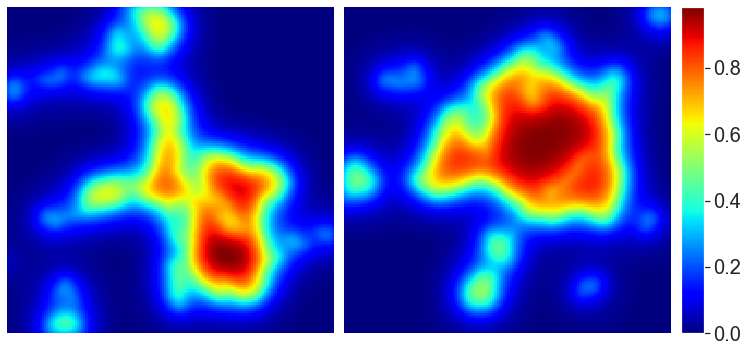

In [90]:
from mpl_toolkits.axes_grid1 import ImageGrid
w_oxford_nonwater=oxfords[0].copy()
w_swindon_nonwater=swindons[0].copy()
for w in [w_oxford_nonwater,w_swindon_nonwater]:
    w[w==2]=0
# Set up figure and image grid
fig = plt.figure(figsize=(20, 6))

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,2),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# Add data to image grid
ims = [fftconvolve(w_oxford_nonwater,kernels[0],mode='same'),
       fftconvolve(w_swindon_nonwater,kernels[0],mode='same')]
for i in range(2):
    im = grid[i].matshow(ims[i],cmap=cm.jet)
    grid[i].axis('off')
# Colorbar
cbar = grid[1].cax.colorbar(im)
cbar.ax.tick_params(labelsize=20) 
grid[1].cax.toggle_label(True)

<AxesSubplot:ylabel='Proportion'>

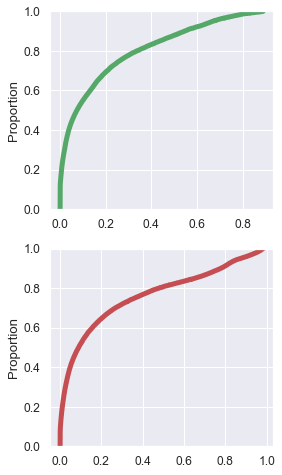

In [104]:
fig,axes = plt.subplots(2,1,figsize=(4,8))
sns.ecdfplot(fftconvolve(w_oxford_nonwater,kernels[0],mode='same').flatten(),lw=5,c='g',ax=axes[0])
sns.ecdfplot(fftconvolve(w_swindon_nonwater,kernels[0],mode='same').flatten(),lw=5,c='r',ax=axes[1])


<AxesSubplot:ylabel='Proportion'>

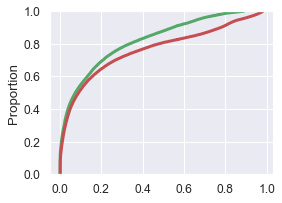

In [107]:
fig,axes = plt.subplots(1,1,figsize=(4,3))
sns.ecdfplot(fftconvolve(w_oxford_nonwater,kernels[0],mode='same').flatten(),ax=axes,lw=3,c='g')
sns.ecdfplot(fftconvolve(w_swindon_nonwater,kernels[0],mode='same').flatten(),ax=axes,lw=3,c='r')

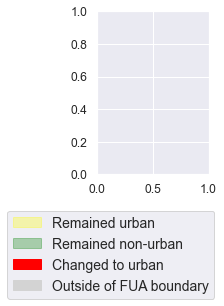

In [112]:
fig,axes = plt.subplots(1,1,figsize=(2,3))
yellow_patch = mpatches.Patch(color=to_rgba('yellow', 0.3), label='Remained urban')
green_patch = mpatches.Patch(color=to_rgba('green', 0.3), label='Remained non-urban')
red_patch = mpatches.Patch(color='red', label='Changed to urban')
grey_patch = mpatches.Patch(color='lightgrey', label='Outside of FUA boundary')
_ = fig.legend(handles=[yellow_patch,green_patch,red_patch,grey_patch], bbox_to_anchor=(0.99,-0.01),fontsize=14, ncol=1)

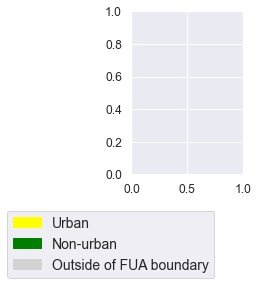

In [113]:
fig,axes = plt.subplots(1,1,figsize=(2,3))
yellow_patch = mpatches.Patch(color='yellow', label='Urban')
green_patch = mpatches.Patch(color='green', label='Non-urban')
grey_patch = mpatches.Patch(color='lightgrey', label='Outside of FUA boundary')
_ = fig.legend(handles=[yellow_patch,green_patch,grey_patch], bbox_to_anchor=(0.75,-0.01),fontsize=14, ncol=1)

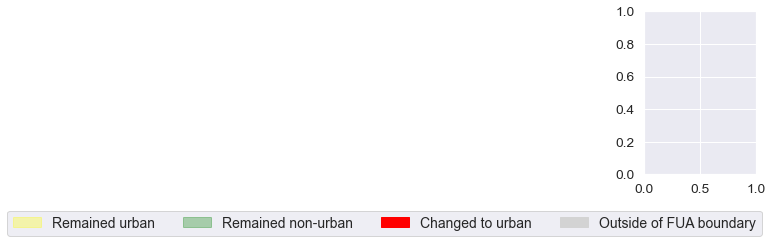

In [143]:
fig,axes = plt.subplots(1,1,figsize=(2,3))
yellow_patch = mpatches.Patch(color=to_rgba('yellow', 0.3), label='Remained urban')
green_patch = mpatches.Patch(color=to_rgba('green', 0.3), label='Remained non-urban')
red_patch = mpatches.Patch(color='red', label='Changed to urban')
grey_patch = mpatches.Patch(color='lightgrey', label='Outside of FUA boundary')
_ = fig.legend(handles=[yellow_patch,green_patch,red_patch,grey_patch], bbox_to_anchor=(0.99,-0.01),fontsize=14, ncol=4)

In [3]:
ghs_built_raster_paths = [r'data\GHS_BUILT_LDS1975_GLOBE_R2018A_54009_250_V2_0\GHS_BUILT_LDS1975_GLOBE_R2018A_54009_250_V2_0.tif',
                          r'data\GHS_BUILT_LDS1990_GLOBE_R2018A_54009_250_V2_0\GHS_BUILT_LDS1990_GLOBE_R2018A_54009_250_V2_0.tif',
                          r'data\GHS_BUILT_LDS2000_GLOBE_R2018A_54009_250_V2_0\GHS_BUILT_LDS2000_GLOBE_R2018A_54009_250_V2_0.tif',
                          r'data\GHS_BUILT_LDS2014_GLOBE_R2018A_54009_250_V2_0\GHS_BUILT_LDS2014_GLOBE_R2018A_54009_250_V2_0.tif']
years = ['1975','1990','2000','2014']

def categorize_urban(percent):
    if percent >= 50: #urban centre
        return 1
    if percent >= 20 and percent < 50: #urban cluster
        return 1 
    if percent >= 0 and percent < 20: #non-urban
        return 0 
    if percent < 0: #no value
        return -200
    
def categorize_urban_road(percent):
    if percent >= 50: #urban centre
        return 1
    if percent >= 30 and percent < 50: #urban cluster
        return 1 
    if percent > 3 and percent < 30: #non-urban
        return 0 
    if percent <= 3: #no value
        return -200
    
categorize_urban_vec = np.vectorize(categorize_urban)
categorize_urban_vec_road = np.vectorize(categorize_urban_road)

fua_gdf = gpd.read_file(r'data\GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0\GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')

In [4]:
def GrowthUnits_InitialMap(CntyName,FUAname):
    fua_gdf = gpd.read_file(r'data\GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0\GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')
    country_gpd = fua_gdf[fua_gdf['Cntry_name']==CntyName]
    shape = country_gpd[country_gpd['eFUA_name']==FUAname].iloc[0]['geometry']
    with rio.open(ghs_built_raster_paths[0]) as src:    
        out_img, out_transform = mask(src, shape, crop=True)
    categorized_FUA_1975 = np.squeeze(categorize_urban_vec(out_img))
    with rio.open(ghs_built_raster_paths[1]) as src:    
        out_img, out_transform = mask(src, shape, crop=True)
    categorized_FUA_1990 = np.squeeze(categorize_urban_vec(out_img))
    with rio.open(ghs_built_raster_paths[2]) as src:    
        out_img, out_transform = mask(src, shape, crop=True)
    categorized_FUA_2000 = np.squeeze(categorize_urban_vec(out_img))
    with rio.open(ghs_built_raster_paths[3]) as src:    
        out_img, out_transform = mask(src, shape, crop=True)
    categorized_FUA_2014 = np.squeeze(categorize_urban_vec(out_img))
    #1975-1990 Dresden: +593
    GrownUrbanUnits_1975_1990 = np.unique(categorized_FUA_1990,return_counts=True)[1][2]-np.unique(categorized_FUA_1975,return_counts=True)[1][2]
    #1975-2000 Dresden: +1153
    GrownUrbanUnits_1975_2000 = np.unique(categorized_FUA_2000,return_counts=True)[1][2]-np.unique(categorized_FUA_1975,return_counts=True)[1][2]
    #1975-2014 Dresden: +1485
    GrownUrbanUnits_1975_2014 = np.unique(categorized_FUA_2014,return_counts=True)[1][2]-np.unique(categorized_FUA_1975,return_counts=True)[1][2]
    categorized_fuas = [categorized_FUA_1975,categorized_FUA_1990,categorized_FUA_2000,categorized_FUA_2014]
    growth_units = [GrownUrbanUnits_1975_1990,GrownUrbanUnits_1975_2000,GrownUrbanUnits_1975_2014]
    return categorized_fuas,growth_units

In [5]:
kernels=[kernel_expo_square(0.01,beta) for beta in [0.2,0.5,2.0]]

In [6]:
FUAs = [ 'Avignon','Poitiers','Belfast','Blackwater','Enschede','Utrecht','Leuven',
        'Mons','Mönchengladbach','Wuppertal']
countries = ['France','France','UnitedKingdom','UnitedKingdom','Netherlands','Netherlands',
             'Belgium','Belgium','Germany','Germany']
country_fua_zip = zip(FUAs,countries)

In [7]:
GrowthUnits_InitialMaps = [GrowthUnits_InitialMap(pair[1],pair[0]) for pair in country_fua_zip]
categorized_FUA_1975s = [GrowthUnits_InitialMaps[j][0][0] for j in range(10)]
categorized_FUA_1990s = [GrowthUnits_InitialMaps[j][0][1] for j in range(10)]
categorized_FUA_2000s = [GrowthUnits_InitialMaps[j][0][2] for j in range(10)]
categorized_FUA_2014s = [GrowthUnits_InitialMaps[j][0][3] for j in range(10)]
prediction_growth_nums = [(GrowthUnits_InitialMaps[j][1][2] - GrowthUnits_InitialMaps[j][1][1]) for j in range(10)]

C:\Users\reneryu\anaconda3\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\reneryu\anaconda3\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\reneryu\anaconda3\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in sh

In [41]:
initialmaps = []
for i in range(10):
    initialmap = categorized_FUA_2000s[i].copy()
    initialmap[initialmap==1]=0 
    initialmaps.append(initialmap)
urban_nums = [(categorized_FUA==1).sum() for categorized_FUA in categorized_FUA_2000s]

In [44]:
#changes paras
paths = [ r'results_EU\changes_kl\Avignon_m_chain2.npy',r'results_EU\changes_kl\Poitiers_m_chain2.npy',
         r'results_EU\changes_kl\Belfast_m_chain2.npy',r'results_EU\changes_kl\Blackwater_m_chain2.npy',
         r'results_EU\changes_kl\Enschede_m_chain2.npy',r'results_EU\changes_kl\Utrecht_m_chain2.npy',
         r'results_EU\changes_kl\Leuven_m_chain2.npy',r'results_EU\changes_kl\Mons_m_chain2.npy', 
         r'results_EU\changes_kl\Mönchengladbach_m_chain2.npy',r'results_EU\changes_kl\Wuppertal_m_chain2.npy']
chains = [np.load(path,allow_pickle=True) for path in paths]
paras = [chain[0][chain[2].argsort()[:1]][0] for chain in chains]
seeds = [chain[1][chain[2].argsort()[:1]][0] for chain in chains]

In [45]:
rows,cols = 180,180
initialmap = np.zeros((rows,cols))
urban_num = 4000
best_changes_pattern = [CCA_EU.CCA_last_snapshot([paras[i][0],0,paras[i][1]],
                                            [0,paras[i][2],paras[i][3]],
                                            seed=seeds[i],landmap=initialmap.copy(),
                                            rows=rows,cols=cols,
                                            urban_num=urban_num,trans_num=15) for i in range(10)] 

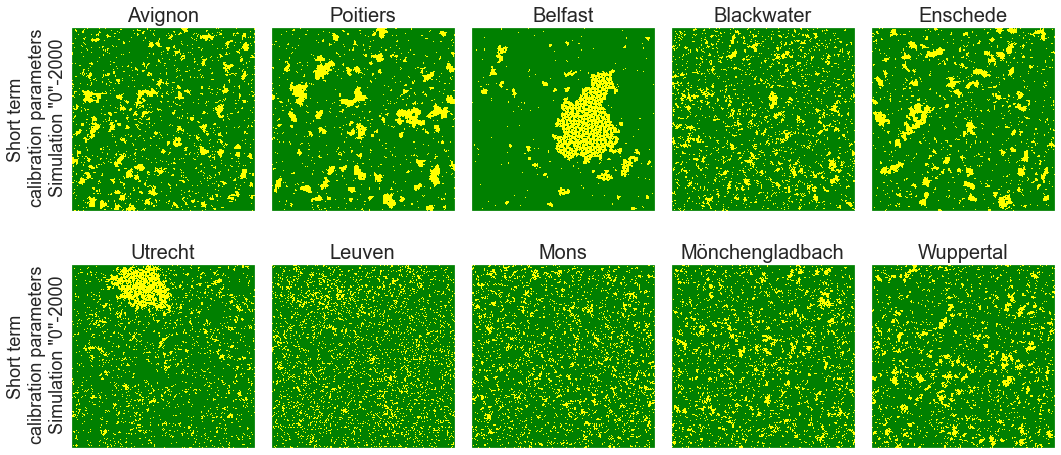

In [47]:
cmap = ListedColormap(["green", "yellow"])
fig,axes = plt.subplots(2,5,figsize=(15,7))
for i in range(5):
    result_plot = best_changes_pattern[i].copy()
    result_plot[result_plot==-200]=0
    chm_plot = axes[0][i].matshow(result_plot,cmap=cmap)
    plt.setp(axes[0][i].get_xticklabels(), visible=False)
    plt.setp(axes[0][i].get_yticklabels(), visible=False)
    axes[0][i].tick_params(axis='both', which='both', length=0)
    axes[0][i].set_title(FUAs[i], fontsize=20)
    axes[0][i].grid(False)
axes[0][0].set_ylabel("Short term\n calibration parameters\n Simulation \"0\"-2000", fontsize=18)
for i in range(5):
    result_plot = best_changes_pattern[i+5].copy()
    result_plot[result_plot==-200]=0
    chm_plot = axes[1][i].matshow(result_plot,cmap=cmap)
    plt.setp(axes[1][i].get_xticklabels(), visible=False)
    plt.setp(axes[1][i].get_yticklabels(), visible=False)
    axes[1][i].tick_params(axis='both', which='both', length=0)
    axes[1][i].set_title(FUAs[i+5], fontsize=20)
    axes[1][i].grid(False)
axes[1][0].set_ylabel("Short term\n calibration parameters\n Simulation \"0\"-2000", fontsize=18)
fig.tight_layout()

In [49]:
def ks_dis(obs,sim):
    obs_urbandensity0 = fftconvolve(obs,kernels[0],mode='same')[obs==1].flatten()
    obs_urbandensity1 = fftconvolve(obs,kernels[1],mode='same')[obs==1].flatten()
    obs_urbandensity2 = fftconvolve(obs,kernels[2],mode='same')[obs==1].flatten()
    simulation_urbandensity0 = fftconvolve(sim,kernels[0],mode='same')[sim==1].flatten()
    statistic0, pvalue = ks_2samp(obs_urbandensity0,simulation_urbandensity0)
    simulation_urbandensity2 = fftconvolve(sim,kernels[2],mode='same')[sim==1].flatten()
    statistic2, pvalue = ks_2samp(obs_urbandensity2,simulation_urbandensity2)
    simulation_urbandensity1 = fftconvolve(sim,kernels[1],mode='same')[sim==1].flatten()
    statistic1, pvalue = ks_2samp(obs_urbandensity1,simulation_urbandensity1)
    return (statistic0+statistic2+statistic1) 

In [52]:
dm = [[ks_dis(best_changes_pattern[i],best_changes_pattern[j]) for j in range(10)] for i in range(10)]

In [55]:
print(pd.DataFrame(dm))

         0        1        2        3        4        5        6        7  \
0  0.00000  0.83600  1.86075  0.55575  0.55325  0.74675  1.25250  1.11725   
1  0.83600  0.00000  1.28725  1.30825  0.39525  0.86775  1.86975  1.78325   
2  1.86075  1.28725  0.00000  2.15125  1.51950  1.40275  2.47200  2.41200   
3  0.55575  1.30825  2.15125  0.00000  1.06950  0.85450  0.77325  0.61375   
4  0.55325  0.39525  1.51950  1.06950  0.00000  0.74200  1.67900  1.57275   
5  0.74675  0.86775  1.40275  0.85450  0.74200  0.00000  1.11350  1.02775   
6  1.25250  1.86975  2.47200  0.77325  1.67900  1.11350  0.00000  0.33925   
7  1.11725  1.78325  2.41200  0.61375  1.57275  1.02775  0.33925  0.00000   
8  0.76975  1.48725  2.23050  0.26075  1.25700  0.89525  0.55725  0.38650   
9  0.40725  1.18075  2.09700  0.17850  0.92825  0.82100  0.90300  0.74725   

         8        9  
0  0.76975  0.40725  
1  1.48725  1.18075  
2  2.23050  2.09700  
3  0.26075  0.17850  
4  1.25700  0.92825  
5  0.89525  0.82100 

In [60]:
np.asarray(dm)[:5,:5]

array([[0.     , 0.836  , 1.86075, 0.55575, 0.55325],
       [0.836  , 0.     , 1.28725, 1.30825, 0.39525],
       [1.86075, 1.28725, 0.     , 2.15125, 1.5195 ],
       [0.55575, 1.30825, 2.15125, 0.     , 1.0695 ],
       [0.55325, 0.39525, 1.5195 , 1.0695 , 0.     ]])

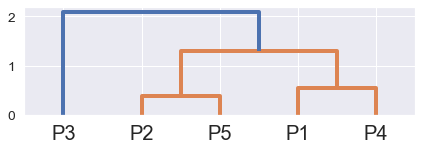

In [81]:
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 4

dis = squareform(np.asarray(dm)[:5,:5], force='tovector', checks=True)
Z = hierarchy.linkage(dis, 'ward')
fig,axes = plt.subplots(1,1,figsize=(7, 2))
dn = hierarchy.dendrogram(Z,ax=axes,labels=['P1','P2','P3','P4','P5'])
axes.tick_params(axis='x', which='major', labelsize=20)

In [9]:
with open(r'D:\research\kl_maps\results2000_2014_genesis.pickle', 'rb') as handle:
    results_2000_2014_genesis = pickle.load(handle)
with open(r'D:\research\kl_maps\results2000_2014_change.pickle', 'rb') as handle:
    results_2000_2014_change = pickle.load(handle)

In [10]:
results_change_best = [[results_2000_2014_change[i][j][0] for j in range(10)] for i in range(10)]
results_pattern_best = [[results_2000_2014_genesis[i][j][0] for j in range(10)] for i in range(10)]

In [19]:
def predicted_changes(i=0):
    changes_colours = ListedColormap(['white','red'])
    Avignon_change = results_change_best[i]
    Avignon_pattern = results_pattern_best[i]
    fig,axes = plt.subplots(4,6,figsize=(20,13))
    cmap = ListedColormap(["green", "yellow"])
    for j in range(11):
        if j == 0:
            result_plot = categorized_FUA_2000s[i].copy()
            result_plot[result_plot==-200]=0
            chm_plot =axes[0][j].matshow(result_plot,cmap=cmap)
            previous = categorized_FUA_2000s[i].copy()
            previous[previous==-200]=0
            result_plot = categorized_FUA_2014s[i].copy()
            result_plot[result_plot==-200]=0
            changes = result_plot-previous
            show(changes,ax=axes[0][j],cmap=changes_colours,alpha=0.7)
            axes[0][j].set_title(FUAs[i]+' \n2000-2014 observation',fontsize=20,y=0.97)

        else:
            result_plot = categorized_FUA_2000s[i].copy()
            result_plot[result_plot==-200]=0
            chm_plot =axes[2*((j-1)//5)][(j-1)%5+1].matshow(result_plot,cmap=cmap)
            result_plot = np.asarray(Avignon_change[j-1].copy())
            result_plot[result_plot==-200]=0
            previous = categorized_FUA_2000s[i].copy()
            previous[previous==-200]=0
            changes = result_plot-previous
            show(changes,ax=axes[2*((j-1)//5)][(j-1)%5+1],cmap=changes_colours,alpha=0.7)
#             axes[2*((j-1)//5)][(j-1)%5+1].set_title(FUAs[j-1]+'\'s \nshort term parameter',fontsize=20,y=0.97)
    for j in range(11):
        if j == 0:
            pass
        else:
            result_plot = categorized_FUA_2000s[i].copy()
            result_plot[result_plot==-200]=0
            chm_plot =axes[((j-1)//5)*2+1][(j-1)%5+1].matshow(result_plot,cmap=cmap)
            result_plot = np.asarray(Avignon_pattern[j-1].copy())
            result_plot[result_plot==-200]=0
            previous = categorized_FUA_2000s[i].copy()
            previous[previous==-200]=0
            changes = result_plot-previous
            show(changes,ax=axes[((j-1)//5)*2+1][(j-1)%5+1],cmap=changes_colours,alpha=0.7)
#             axes[((j-1)//5)*2+1][(j-1)%5+1].set_title(FUAs[j-1]+'\'s \nlong term parameter',fontsize=20,y=0.97)
    [axi.set_axis_off() for axi in axes.ravel()]
    red_patch = mpatches.Patch(color='red', label='Urban growth')
    yellow_patch = mpatches.Patch(color='yellow', label='Urban')
    green_patch = mpatches.Patch(color='green', label='Non-urban')
    _ = fig.legend(handles=[red_patch,yellow_patch,green_patch], bbox_to_anchor=(0.16,0.75),fontsize=20)
    fig.tight_layout()

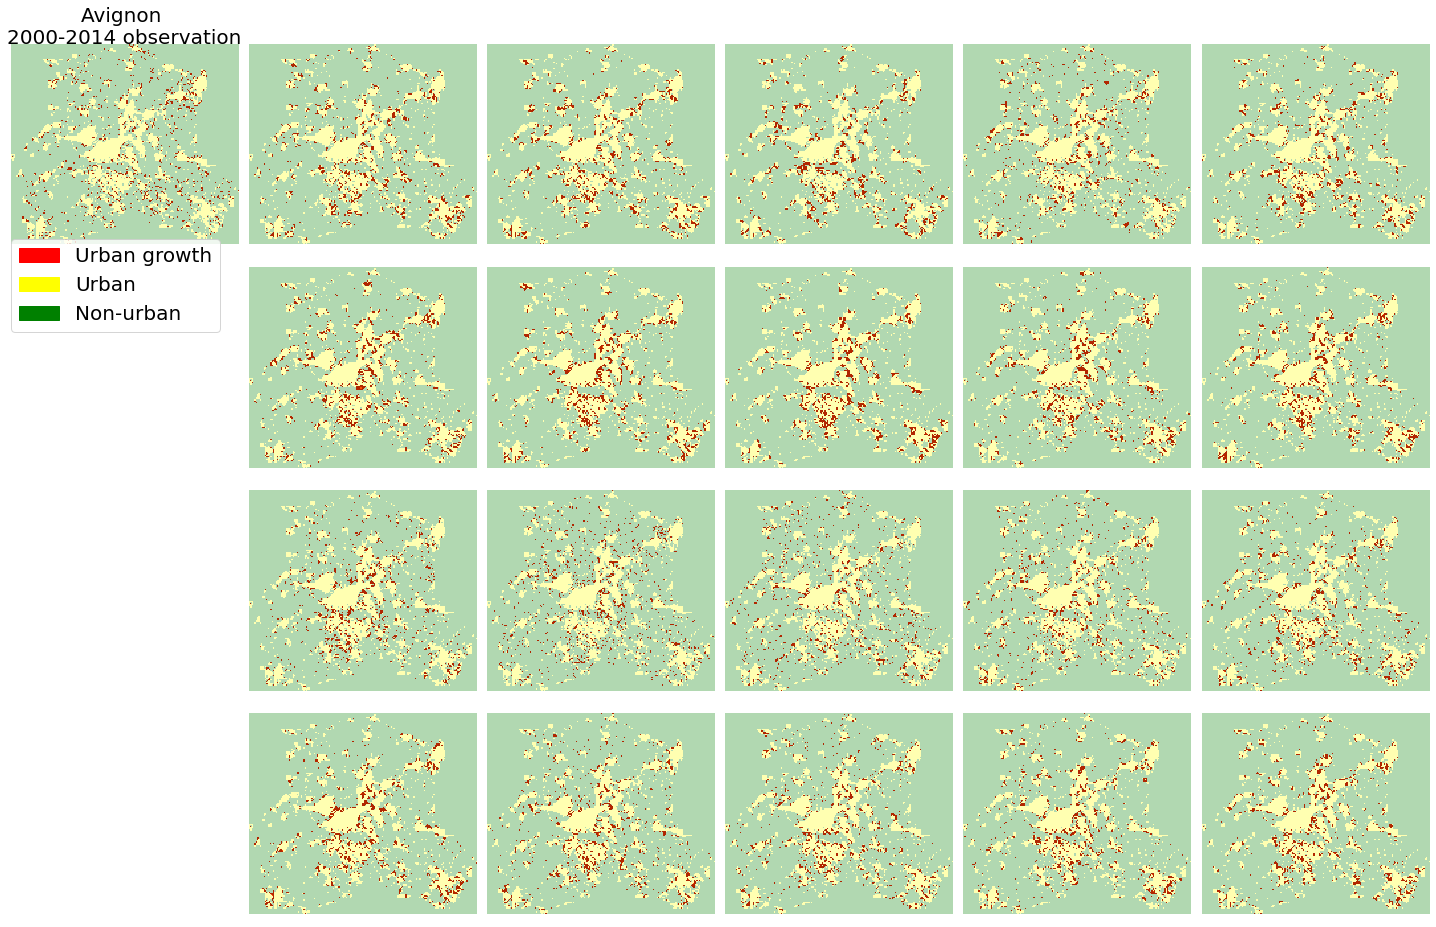

In [20]:
predicted_changes(i=0)

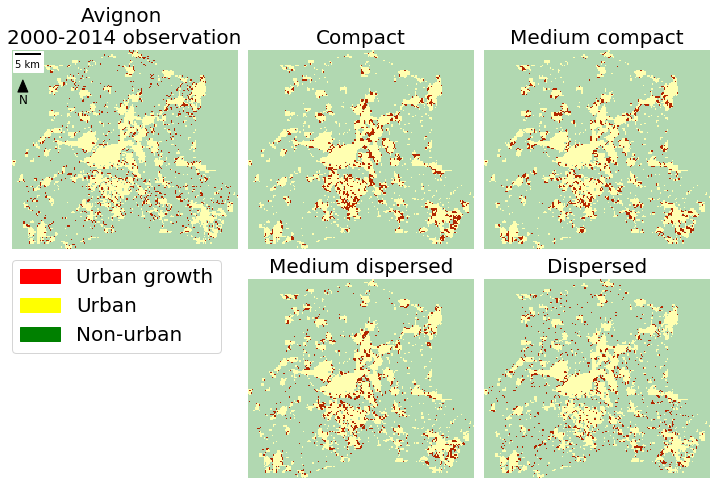

In [37]:
changes_colours = ListedColormap(['white','red'])
Avignon_change = results_change_best[0]
Avignon_pattern = results_pattern_best[0]
fig,axes = plt.subplots(2,3,figsize=(10,7))
cmap = ListedColormap(["green", "yellow"])

obs2000 = categorized_FUA_2000s[0].copy()
obs2014 = categorized_FUA_2014s[0].copy()
compact_pattern = Avignon_pattern[2]
mediumC_pattern = Avignon_change[1]
mediumD_pattern = Avignon_pattern[-2]
dispersed_pattern = Avignon_change[-3]
simulations = [compact_pattern,mediumC_pattern,mediumD_pattern,dispersed_pattern]
subtitles = ['Compact','Medium compact','Medium dispersed','Dispersed']

#plot observation
result_plot = obs2000
result_plot[result_plot==-200]=0
chm_plot =axes[0][0].matshow(result_plot,cmap=cmap)
previous = obs2000
previous[previous==-200]=0
result_plot = obs2014
result_plot[result_plot==-200]=0
changes = result_plot-previous
show(changes,ax=axes[0][0],cmap=changes_colours,alpha=0.7)
axes[0][0].set_title(FUAs[0]+' \n2000-2014 observation',fontsize=20,y=1.)
scalebar = ScaleBar(250,location='upper left') 
axes[0][0].add_artist(scalebar)
x, y, arrow_length = 0.05, 0.85, 0.0
axes[0][0].annotate('N', xy=(x, y), xytext=(x, y-0.1),
        arrowprops=dict(facecolor='black', width=5, headwidth=10),
        ha='center', va='center', fontsize=12,
        xycoords=axes[0][0].transAxes)

for i in range(4):
    result_plot = obs2000
    result_plot[result_plot==-200]=0
    chm_plot =axes[i//2][i%2+1].matshow(result_plot,cmap=cmap)
    result_plot = np.asarray(simulations[i].copy())
    result_plot[result_plot==-200]=0
    previous = obs2000
    previous[previous==-200]=0
    changes = result_plot-previous
    show(changes,ax=axes[i//2][i%2+1],cmap=changes_colours,alpha=0.7)
    axes[i//2][i%2+1].set_title(subtitles[i],fontsize=20,y=1.)

[axi.set_axis_off() for axi in axes.ravel()]
red_patch = mpatches.Patch(color='red', label='Urban growth')
yellow_patch = mpatches.Patch(color='yellow', label='Urban')
green_patch = mpatches.Patch(color='green', label='Non-urban')
_ = fig.legend(handles=[red_patch,yellow_patch,green_patch], bbox_to_anchor=(0.32,0.5),fontsize=20)
fig.tight_layout()

In [38]:
countries = ['Austria','Denmark','Finland','Greece','Hungary','Italy','Luxembourg','Norway',
             'Portugal','Slovakia','Spain','Sweden','Switzerland','Turkey']
FUAs = ['Linz','Aarhus','Helsinki','Thessaloniki','Debrecen','Verona','Luxembourg','Bergen',
        'Braga','Bratislava','Seville','Malmö','Bern','Ankara']
# 'Częstochowa','Poland',
country_fua_zip = zip(FUAs,countries)

In [39]:
GrowthUnits_InitialMaps = [GrowthUnits_InitialMap(pair[1],pair[0]) for pair in country_fua_zip]
categorized_FUA_1975s = [GrowthUnits_InitialMaps[j][0][0] for j in range(len(FUAs))]
categorized_FUA_1990s = [GrowthUnits_InitialMaps[j][0][1] for j in range(len(FUAs))]
categorized_FUA_2000s = [GrowthUnits_InitialMaps[j][0][2] for j in range(len(FUAs))]
categorized_FUA_2014s = [GrowthUnits_InitialMaps[j][0][3] for j in range(len(FUAs))]

C:\Users\reneryu\anaconda3\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\reneryu\anaconda3\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
C:\Users\reneryu\anaconda3\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in sh

C:\Users\reneryu\anaconda3\lib\site-packages\rasterio\features.py:441: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  all_bounds = [bounds(shape, transform=~dataset.transform) for shape in shapes]
C:\Users\reneryu\anaconda3\lib\site-packages\rasterio\features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):


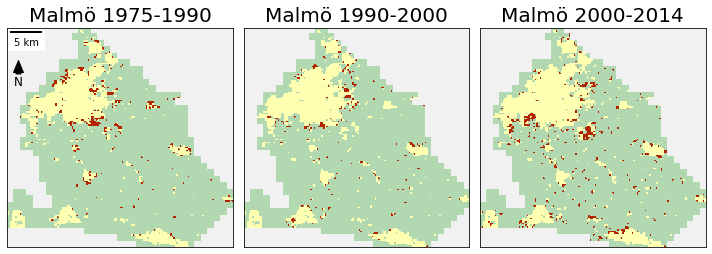

In [49]:
changes_colours = ListedColormap(['white','red'])
cmap = ListedColormap(["lightgrey","green", "yellow"])
fig,axes = plt.subplots(1,3,figsize=(10,5))
indices = 11
j=indices
former_plots = [categorized_FUA_1975s[j].copy(),categorized_FUA_1990s[j].copy(),categorized_FUA_2000s[j].copy()]
latter_plots = [categorized_FUA_1990s[j].copy(),categorized_FUA_2000s[j].copy(),categorized_FUA_2014s[j].copy()]
time_periods = [' 1975-1990',' 1990-2000',' 2000-2014']
for i in range(3):
    #1975-1990
    result_plot = former_plots[i].copy()
    result_plot[result_plot==-200]=-1
    chm_plot = axes[i].matshow(result_plot,cmap=cmap)
    previous = former_plots[i].copy()
    previous[previous==-200]=0
    result_plot = latter_plots[i].copy()
    result_plot[result_plot==-200]=0
    changes = result_plot-previous
    show(changes,ax=axes[i],cmap=changes_colours,alpha=0.7)
    plt.setp(axes[i].get_xticklabels(), visible=False)
    plt.setp(axes[i].get_yticklabels(), visible=False)
    axes[i].set_title(FUAs[j]+time_periods[i],fontsize=20)
    axes[i].tick_params(axis='both', which='both', length=0)
    if i == 0:
        scalebar = ScaleBar(250,location='upper left') 
        axes[i].add_artist(scalebar)
        x, y, arrow_length = 0.05, 0.85, 0.0
        axes[i].annotate('N', xy=(x, y), xytext=(x, y-0.1),
        arrowprops=dict(facecolor='black', width=5, headwidth=10),
        ha='center', va='center', fontsize=12,
        xycoords=axes[i].transAxes)
fig.tight_layout()